In [ ]:
## @see https://www.kaggle.com/toorkp/churn-wsdm/data

In [1]:
%load_ext autoreload
%autoreload

In [2]:
import numpy as np
import pandas as pd
import time
import gc; gc.enable()
import time
import sys

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, f1_score, log_loss, confusion_matrix

from collections import Counter
from numpy.random import RandomState
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

pd.options.display.float_format = "{:.2f}".format
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('modules')

from shared_functions import *
import pickle
from datetime import datetime

/home/anaconda/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/anaconda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
# Load the pre-split data

store = pd.HDFStore('/home/dissertation/data/feat_eng_abt_split.h5')
X_train, X_test, y_train, y_test = store['X_train'], store['X_test'], store['y_train'], store['y_test']
store.close()

# Drop msno from the dataset
X_train.drop(['msno', 'registration_init_time', 'registration_init_time_dt'], inplace=True, axis=1, errors='ignore')
X_test.drop(['msno', 'registration_init_time', 'registration_init_time_dt'], inplace=True, axis=1, errors='ignore')

print("Train Shape:", X_train.shape, y_train.shape)
print("Train Shape:", X_test.shape, y_test.shape)
X_train.head()

Train Shape: (600803, 17) (600803,)
Train Shape: (257487, 17) (257487,)


,city,bd,gender,registered_via,membership_months,total_order,payment_method_id_mode,payment_method_id_count,payment_plan_days_mode,payment_plan_days_mean,plan_list_price_mean,plan_lifetime_value,actual_amount_mean,total_actual_amount,is_auto_renew_mode,cancel_times,transaction_date_delta
0,5,28,male,3,38,6,31,2,0,10.00,49.67,298.00,149.00,894.00,True,1,700.00
1,13,20,male,3,38,5,38,3,30,25.40,125.40,627.00,125.40,627.00,False,0,344.00
2,13,18,male,3,38,18,38,1,30,30.00,149.00,2682.00,149.00,2682.00,False,0,530.00
3,1,0,unknown,7,37,19,41,2,30,25.63,125.47,2384.00,141.16,2682.00,True,3,413.00
4,13,35,female,7,37,24,41,1,30,26.25,105.38,2529.00,123.17,2956.00,True,2,586.00


In [6]:
RANDOM_STATE = 42 
CV_ITER = None
SCORING_METRIC = autosklearn.metrics.recall
BASE_NAME = "askbasic_" + str(CV_ITER) + "cv_" + str(SCORING_METRIC)
N_JOBS = 8
## Time periods to train for in minutes
# TIME_PERIODS = [0.25, 0.5, 1, 2, 3, 4]
TIME_PERIODS = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
TIME_PERIODS = [45]

## Set the list of the categorical columns in the dataset
cat_col = ['city', 'gender', 'registered_via', 'payment_method_id_mode']

df_cols = X_train.columns
feat_types =  ['Categorical' if col in cat_col else 'Numerical' for col in df_cols]

classifiers = []

## Each entry in the list is a Tuple of
##   [ModelName, Model, HyperParams, ScoringMetric]    
for period in TIME_PERIODS:
    classifiers.append(
        ('ASKLEARN_{}_'.format(str(period)) + BASE_NAME,                        ## ModelName
         autosklearn.classification.AutoSklearnClassifier(                      ## Model  
                time_left_for_this_task=int(60*period), 
                n_jobs=N_JOBS,
                include_estimators=["random_forest", "decision_tree", "adaboost", "gaussian_nb",
                                    "liblinear_svc", "xgradient_boosting"], 
                exclude_estimators=None,
                include_preprocessors=["no_preprocessing", ], 
                exclude_preprocessors=None,
                ml_memory_limit = 3072*9), 
         {},                                                                    ## HyperParams
         SCORING_METRIC)                                                        ## ScoringMetric 
    )

In [5]:
all_metrics = pd.DataFrame()
all_results = list()

In [ ]:
# with open('/tmp/INITIAL_manask_all_metrics.pickle', 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     all_metrics = pickle.load(f)

# with open('/tmp/INITIAL_manask_all_results.pickle', 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     all_results = pickle.load(f)

In [ ]:
# # Write (overwrite) the file to store the experiment results
# with open('/tmp/INITIAL_manask_all_metrics.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     print("Writing results to", f.name)
#     pickle.dump(all_metrics, f, pickle.HIGHEST_PROTOCOL)
    
# # Write (overwrite) the file to store the experiment results
# with open('/tmp/INITIAL_manask_all_results.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     print("Writing results to", f.name)
#     pickle.dump(all_results, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# # Write (overwrite) the file to store the experiment results
# with open('/tmp/ADDITIONAL_manask_all_metrics.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     print("Writing results to", f.name)
#     pickle.dump(all_metrics, f, pickle.HIGHEST_PROTOCOL)
    
# # Write (overwrite) the file to store the experiment results
# with open('/tmp/ADDITIONAL_manask_all_results.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     print("Writing results to", f.name)
#     pickle.dump(all_results, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
### COPMLETED ::: RUS 1:1

### Experiment 1.1 Baseline - Default Settings - No sampling

Model Build Iteration 0
PRE-SAMPLING: (600803, 17) (600803,) Counter({0: 544661, 1: 56142})
POST-SAMPLING: (600803, 17) (600803,) Counter({0: 544661, 1: 56142})
Set the train df types correctly based on the test set
Applying normalisation to train and test sets
Categorical columns in dataset ['city', 'gender', 'registered_via', 'payment_method_id_mode']
Categorical columns in dataset ['city', 'gender', 'registered_via', 'payment_method_id_mode']
X_train:  (600803, 51) (600803, 1)
X_test:  (257487, 51) (257487, 1)


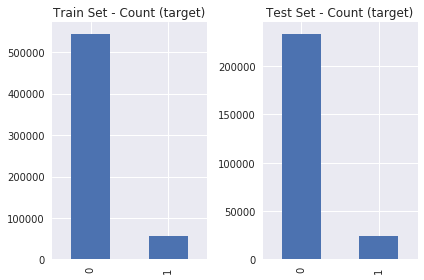

Training ASKLEARN_45_askbasic_Nonecv_recall classifier
No params set, using Standard training


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-16 11:29:28,995:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:29:29,150:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-16 11:29:31,397:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-16 11:29:33,551:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:29:35,608:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:29:37,644:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:29:39,672:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-16 11:29:41,746:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:29:43,760:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:29:45,824:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-16 11:29:47,923:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:29:49,946:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:29:50,780:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-16 11:29:50,780:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-16 11:29:52,033:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:29:54,064:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:29:56,088:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:29:58,100:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:30:00,118:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:30:02,148:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:30:04,164:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-16 11:30:08,257:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:30:10,284:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:30:12,308:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:30:14,331:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:30:16,350:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:30:18,376:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:30:20,400:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-16 11:30:30,586:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:30:32,630:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:30:34,660:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:30:36,688:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:30:38,712:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:30:40,740:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:30:42,768:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than

[WARNING] [2019-08-16 11:32:24,164:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!
[WARNING] [2019-08-16 11:32:26,192:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] No models better than random - using Dummy Score!


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

[WARNING] [2019-08-16 11:48:40,245:EnsembleBuilder(1791095845):8d48db485c7ed9dc3246ec8a9f87dba2] Memory Exception -- restart with less ensemle_nbest: 25


/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: Runti

/home/anaconda/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


-1
['/tmp/autosklearn_tmp_3690_8731/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_3690_8731/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_3690_8731/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_3690_8731/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_3690_8731/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_3690_8731/.auto-sklearn/ensembles/1791095845.0000000005.ensemble', '/tmp/autosklearn_tmp_3690_8731/.auto-sklearn/ensembles/1791095845.0000000006.ensemble', '/tmp/autosklearn_tmp_3690_8731/.auto-sklearn/ensembles/1791095845.0000000007.ensemble', '/tmp/autosklearn_tmp_3690_8731/.auto-sklearn/ensembles/1791095845.0000000008.ensemble', '/tmp/autosklearn_tmp_3690_8731/.auto-sklearn/ensembles/1791095845.0000000009.ensemble', '/tmp/autosklearn_tmp_3690_8731/.auto-sklearn/ensembles/1791095845.0000000010.ensemble']
Generating test s

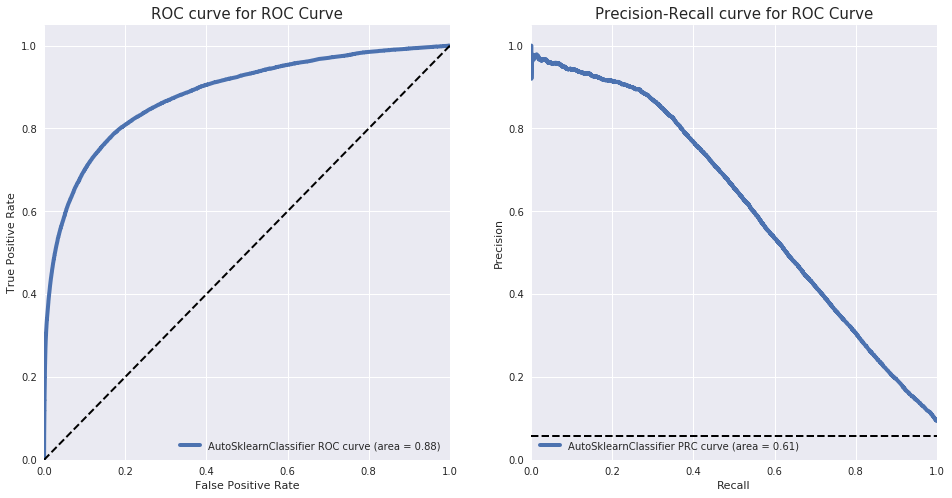

CPU times: user 2min 21s, sys: 11.3 s, total: 2min 33s
Wall time: 45min 46s


In [7]:
%%time
start = time.time()

sampler = ('None', DummySampler())

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col, auto_ml = False)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

In [8]:
all_metrics

,label,classifier,sampling_method,tn,fn,tp,fp,accuracy,precision,recall,...,log_loss,train_time,cv_time,aucroc,auprc,balanced_accuracy,cv_score_mean,cv_score_std,model_churn_cost,sample
0,ASKLEARN_45_askbasic_Nonecv_recall,AutoSklearnClassifier,None,231130,15062,8999,2296,0.93,0.80,0.37,...,2.33,2744.13,0.00,0.88,0.61,0.68,-1,-1,8660500,0


In [ ]:
#all_metrics[['sampling_method']].drop_duplicates()

In [ ]:
#all_metrics[['label','sampling_method']].groupby(['sampling_method']).count()

In [ ]:
all_metrics

In [ ]:
all_metrics.groupby(['label']).size()

In [ ]:
all_metrics[all_metrics.label.isin(['ASKLEARN_55_askbasic_Nonecv_recall'])]

### Experiment 1.2 Baseline - Default Settings - Oversampled training set 100%

In [ ]:
%%time
start = time.time()

sampler = ('ROS 1:1', RandomOverSampler(random_state=RANDOM_STATE))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col, auto_ml = False)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

In [ ]:
all_metrics

### Experiment 1.3 Baseline - Default Settings - Undersampled training set

In [ ]:
%%time
start = time.time()

sampler = ('RUS 1:1', RandomUnderSampler(random_state=RANDOM_STATE))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col, auto_ml = False)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

In [ ]:
all_metrics

In [ ]:
# sys.getsizeof(model)
# model = all_results[0][2][0][-1]
# print(model.sprint_statistics())
# print(model.show_models())

### Experiment 1.4 Baseline - Default Settings - Over sampling - 33% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 3:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/3))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col, auto_ml = False)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

In [ ]:
all_metrics.sampling_method.value_counts()

In [ ]:
all_metrics.sort_values(['balanced_accuracy', 'recall'], ascending=[False, False]).head()

### Experiment 1.5 Baseline - Default Settings - Over sampling - 66% of majority size

In [ ]:
# #sampler = ('SMOTE_NC', SMOTENC(random_state=RANDOM_STATE, categorical_features=[0,1,2,3,4,5,6,7,8,13,14], n_jobs=8))
# sampler = ('ROS 3:2', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 2/3))

# X_train_t, X_test_t, y_train_t, y_test_t = \
#     prepare_train_test_data(X_train, X_test, y_train, y_test, 
#                             sampler = RandomOverSampler(random_state=RANDOM_STATE), 
#                             cat_col = cat_col)

In [ ]:
all_metrics

In [ ]:
all_results

In [ ]:
%%time
start = time.time()

sampler = ('ROS 3:2', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 2/3))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col, auto_ml = False)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

### Experiment 1.6 Baseline - Default Settings - Over sampling - 50% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 2:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/2))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col, auto_ml = False)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

### Experiment 1.7 Baseline Default Settings SMOTE-NC

In [ ]:
sampler = ('SMOTE_NC', SMOTENC(random_state=RANDOM_STATE, categorical_features=[0,1,2,3,4,5,6,7,8,13,14], n_jobs=8))

X_train_t, X_test_t, y_train_t, y_test_t = \
    prepare_train_test_data(X_train, X_test, y_train, y_test, 
                            sampler = RandomOverSampler(random_state=RANDOM_STATE), 
                            cat_col = cat_col)

In [ ]:
%%time
start = time.time()
sampler = ('SMOTE_NC', DummySampler())

## Keep the following, essentially dropping the dt columns
cols = ['is_churn', 'city', 'bd', 'registered_via', 'total_order',
       'payment_method_id_mode', 'payment_method_id_count',
       'payment_plan_days_mode', 'payment_plan_days_mean',
       'plan_list_price_mean', 'plan_lifetime_value', 'actual_amount_mean',
       'total_actual_amount', 'is_auto_renew_mode', 'cancel_times']

exp_metrics, model_results = perform_experiment(X_train_t, X_test_t, y_train_t, y_test_t, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=[], auto_ml = False)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

In [ ]:
all_metrics.sort_values('recall', ascending=False).head(15)

In [ ]:
#store(all_results, 'Asklearn_Default_Undersample.pickle')

# Write (overwrite) the file to store the experiment results
with open('Manual_Asklearn_20190816.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    print("Writing results to", f.name)
    pickle.dump(merged_results, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
## Just try an SVM 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [ ]:
%%time
model_train_results = train_model(base_dataset, sampling_method = 'under', classifiers = [('SGDClassifier', SGDClassifier(loss='log'))])

In [ ]:
## Print the feature importance 

feature_index = np.flip(np.argsort(model.feature_importances_), axis=0)
ordered_features = []
column_names = X_test.columns

for i in feature_index[0:10]:
    print(np.round(model.feature_importances_[i], 3), ' --> ', column_names[i])
    ordered_features.append(column_names[i])

In [ ]:
## Print the permutation importance 

import eli5
from eli5.sklearn import PermutationImportance

_, X_test, _, y_test = prepare_train_test_split(model_dataset, 0)

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [ ]:
#model_name, model = model_train_results[1][2]

for model_name, model in model_train_results[1]:
    probs = model.predict_proba(X_test)[:, 1]
    pr_data = plot_precision_recall(
        y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
pr_data = plot_roc(
    y_test, probs, title='ROC Curve for {0}'.format(model_name))

In [ ]:
print(plt.style.available)

In [ ]:
model_dataset.head()

In [ ]:
print("Original Data distribution")
print(model_dataset['is_churn'].value_counts())

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Down Sampled data set')
train_downsample = undersampled_dataset(model_dataset, 'is_churn')

print(train_downsample['is_churn'].value_counts())
print("Num records = ", train_downsample.shape[0])
train_downsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Up Sampled data set')
train_upsample = oversampled_dataset(model_dataset, 'is_churn')

print(train_upsample['is_churn'].value_counts())
print("Num records = ", train_upsample.shape[0])
train_upsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='Precision-Recall Curve for Random Forest')

In [ ]:
precision_above = pr_data.loc[pr_data['precision'] >= 0.25].copy()
precision_above.sort_values('recall', ascending=False, inplace=True)
precision_above.head()

In [ ]:
threshold_required = 0.5
# Make predictions where probability is above threshold
preds = np.zeros(len(y_test))
preds[probs >= threshold_required] = 1

# Make and plot confusion matrix
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=['No Churn', 'Churn'],
                      title='Churn Confusion Matrix')

In [ ]:
model_dataset.head()

In [ ]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=model_dataset.iloc[:, 1:].columns).\
    sort_values('importance', ascending=False)
fi.head(10)

In [ ]:
initial_metrics = pd.DataFrame()
initial_results = list()

additional_metrics = pd.DataFrame()
additional_results = list()

In [ ]:
with open('/tmp/INITIAL_manask_all_metrics.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    initial_metrics = pickle.load(f)

with open('/tmp/INITIAL_manask_all_results.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    initial_results = pickle.load(f)

with open('/tmp/ADDITIONAL_manask_all_metrics.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    additional_metrics = pickle.load(f)

with open('/tmp/ADDITIONAL_manask_all_results.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    additional_results = pickle.load(f)

In [ ]:
additional_metrics

In [ ]:
def load_results(file_name):
    data = None
    with open(file_name, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        data = pickle.load(f)
    return data

In [ ]:
exp_results = load_results('Manual_Asklearn_20190815.pickle')

In [ ]:
additional_results[0][1]

In [ ]:
pd.concat([exp_results[1][1], additional_results[0][1]])

In [ ]:
merged_results = np.copy(exp_results)

In [ ]:
for i in range(0, len(additional_results)):
    for j in range(len(exp_results)):
        if additional_results[i][0] == exp_results[j][0]:
            print(additional_results[i][0])
            # Merge the DF
            merged_results[j][1] = pd.concat([exp_results[j][1], additional_results[i][1]])
            merged_results[j][2] = np.concatenate([exp_results[j][2], additional_results[i][2]])

In [ ]:
merged_results[6][1]

In [ ]:
for i in range(0, len(merged_results)):
    print((merged_results[i][2]))